(2160, 4096, 3)


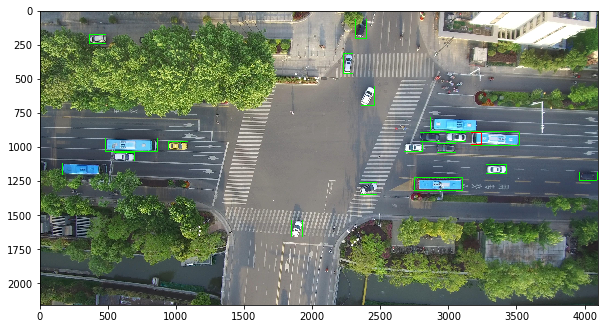

In [9]:
import os.path as osp
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm
import math
# %matplotlib inline


def overlap(x1, len1, x2, len2):
    len1_half = len1 / 2
    len2_half = len2 / 2

    left = max(x1 - len1_half, x2 - len2_half)
    right = min(x1 + len1_half, x2 + len2_half)

    return right - left


def box_intersection(a, b):
    w = overlap(a[0], a[2]-a[0], b[0], b[2]-b[0])
    h = overlap(a[1], a[3]-a[1], b[1], b[3]-b[1])
    
    if w < 0 or h < 0:
        return 0

    area = w * h
    return area

def is_box_inner(a, b):
    '''
    box a, b
    a,b:[x1,y1,x2,y2]
    判断a,b是否存在包含关系
    return:
        True a in b
        False a not in b
    '''
    area_a = (a[2]-a[0])*(a[3]-a[1])
    area_b = (b[2]-b[0])*(b[3]-b[1])
    
    diff_w = math.fabs((a[2]-a[0]) - (b[2]-b[0]))
    diff_h = math.fabs((a[3]-a[1]) - (b[3]-b[1]))
    
    if min(diff_w, diff_h) > 20:
        return False
    
    if area_b-area_a < 0:
        return False
    
    overlap = box_intersection(a,b)
    if overlap > area_a*0.8:
        return True
    else:
        return False
    
# a=[3,2,6,6]
# b=[1,2,6,8]
# is_box_inner(a,b)



def process_result(txt_file, anchor_dist_thresh = 81):
    if not osp.exists(txt_file):
        print("error: file not found error:%s"%txt_file)
        return None
    with open(txt_file) as f:
        boxes = [line.split(",")[:-1] for line in f.readlines()]
    boxes = np.array(boxes, dtype=np.float32)
    #print(boxes[:5])
    removal_indexes = []
    for i in range(boxes.shape[0]):
        a = boxes[i,:]
        for j in range(boxes.shape[0]):
            if i==j: 
                continue
                
            b = boxes[j,:]
            # if a is close to b and a in b then remove a
            distance = ((a[0]-b[0])**2 + (a[1]-b[1])**2)
            if distance < anchor_dist_thresh and is_box_inner(a, b):
                removal_indexes.append(i)
                
    
    return boxes, removal_indexes

def simple_test():
    imageid = "00013481"
    image_file = "/root/datasets/testset/JPEGImages/%s.jpg"%imageid
    txt_file = "/root/mmdetection/data/postprocess/results/results_testset_resampled_merged_txt_dir/%s.txt"%imageid

    boxes, removal_indexes = process_result(txt_file)
    img = cv2.imread(image_file)
    print(img.shape)
    for i in range(boxes.shape[0]):
        box = boxes[i,:]
        if i in removal_indexes:
            cv2.rectangle(img,(int(box[0]), int(box[1])),(int(box[2]),int(box[3])),(0,0,255),2)# red box
        else:
            cv2.rectangle(img,(int(box[0]), int(box[1])),(int(box[2]),int(box[3])),(0,255,0),2)# green box


    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    cv2.imwrite("removal_inner_box_sample.png", img)
    
def process_dataset(input_dir, out_dir, image_dir=None, show=False, result_vis="./results/remove_inner_box"):
    if not osp.exists(out_dir):
        os.makedirs(out_dir)
    if not osp.exists(result_vis):
        os.makedirs(result_vis)
        
    imageids = [file.split(".")[0] for file in os.listdir(input_dir)]
    category = "Vehicle"
    for imageid in tqdm(imageids):
        txt_file = osp.join(input_dir, imageid+".txt")
        boxes, removal_indexes = process_result(txt_file)
        out_txt_file = osp.join(out_dir, imageid+".txt")
        if show and image_dir is not None:
            img = cv2.imread(osp.join(image_dir, imageid+".jpg"))
        out_file = open(out_txt_file, "w")
        for i in range(boxes.shape[0]):
            box = boxes[i,:]
            if i in removal_indexes:
                if show and image_dir is not None:
                    cv2.rectangle(img,(int(box[0]), int(box[1])),(int(box[2]),int(box[3])),(0,0,255),2)# red box
                    cv2.imwrite(osp.join(result_vis, imageid+".jpg"), img)
            else:
                out_file.write("%d,%d,%d,%d,%s\n"%(box[0], box[1], box[2], box[3], category))
                if show and image_dir is not None:
                    cv2.rectangle(img,(int(box[0]), int(box[1])),(int(box[2]),int(box[3])),(0,255,0),2)# green box
                    cv2.imwrite(osp.join(result_vis, imageid+".jpg"), img)
    
        out_file.close()
        
simple_test()
        
# input_dir = "/root/mmdetection/data/postprocess/results/results_testset_resampled_merged_txt_dir"
# out_dir = "/root/mmdetection/data/postprocess/results/results_testset_resampled_merged_txt_removal_innerbox_dir"
# image_dir = "/root/datasets/testset/JPEGImages"
    
# process_dataset(input_dir, out_dir, image_dir=image_dir, show=False)

    
    
    
    
    
    